<a href="https://colab.research.google.com/github/GuilhermeDumam/Loan_default_prediction/blob/Master/Predi%C3%A7%C3%A3o_Default_Loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução:

Este dataset se encontra no 'Kaggle': https://www.kaggle.com/kmldas/loan-default-prediction?select=Default_Fin.csv 


O notebook terá como finalidade a prática de estudos de machine learning, afim de classificar se o cliente é 'default'(inadimplente) ou não nas parcelas do empréstimo da financeira.
Será dividido em:
* Importação bibliotecas e dataset;
* Tratamento e limpeza dos dados;
* EDA;
* Feature Engineering;
* Modelagem;
* Métricas e conclusão.


In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [39]:
df = pd.read_csv('Default_Fin.csv')

In [ ]:
df.head()

,Index,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0


In [ ]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          10000 non-null  int64  
 1   Employed       10000 non-null  int64  
 2   Bank Balance   10000 non-null  float64
 3   Annual Salary  10000 non-null  float64
 4   Defaulted?     10000 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 390.8 KB


(10000, 5)

In [ ]:
df[df.duplicated()].count()

Index            0
Employed         0
Bank Balance     0
Annual Salary    0
Defaulted?       0
dtype: int64

In [ ]:
df.isna().sum()/df.shape[0]

Index            0.0
Employed         0.0
Bank Balance     0.0
Annual Salary    0.0
Defaulted?       0.0
dtype: float64

##Limpeza e Tratamento.

In [40]:
columns_renamed = {'Bank Balance' : 'Bank_Balance',
'Annual Salary' : 'Annual_Salary',
'Defaulted?' : 'Default'
}
df.rename(columns=columns_renamed, inplace=True)

In [41]:
df.columns = map(str.lower, df.columns)

In [42]:
#dropamos a coluna 'index', ela não será útil para nós.
df.drop(columns=['index'], inplace=True)

In [43]:
df['age'] = np.random.randint(18, 60, df.shape[0])

In [44]:
sexo = {'male','female'} 

In [45]:
df['sex'] = np.random.choice(list(sexo), df.shape[0])

In [ ]:
df.tail()

,employed,bank_balance,annual_salary,default,age,sex
9995,1,8538.72,635908.56,0,49,male
9996,1,9095.52,235928.64,0,55,female
9997,1,10144.92,703633.92,0,35,male
9998,1,18828.12,440029.32,0,19,female
9999,0,2411.04,202355.40,0,25,female


Criamos mais duas colunas (idade e sexo), para gerar mais realidade e impactos ao nosso dataset.

## EDA 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


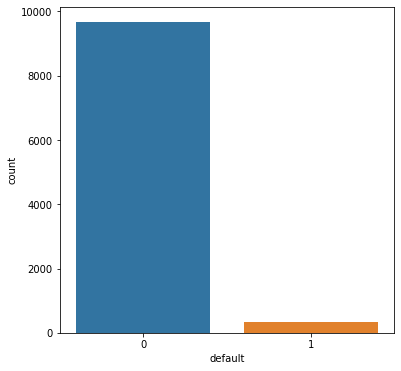

In [ ]:
#balanceamento da feature target
plt.figure(figsize= (6,6))
sns.countplot(df['default'])
plt.show()

Aqui podemos ver que nosso dataset está desbalanceado para não default (não inadimplente); em um cenário real isso é muito bom, mas para nosso modelo de predição, vamos precisar balancear para que ele consiga ter uma taxa de acerto melhor na hora de classificar.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


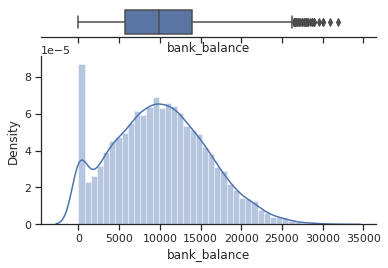

In [12]:
sns.set(style="ticks")

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data= df, x='bank_balance', ax=ax_box)
sns.distplot(df['bank_balance'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

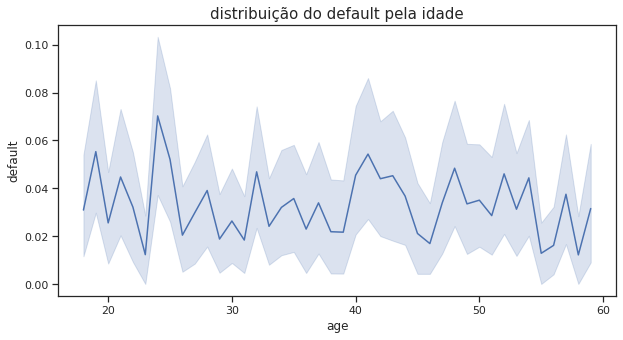

In [27]:
plt.figure(figsize=(10,5))
plt.title("distribuição do default pela idade", fontsize=15)
lines = ['default']
for line in lines:
    ax = sns.lineplot(x='age', y=line, data=df)

In [28]:
numeric_var = ['annual_salary', 'bank_balance', 'age']

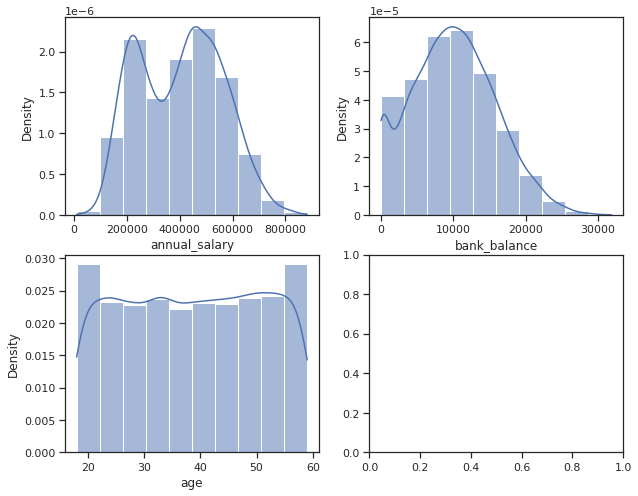

In [32]:
# Olhando a distribuição para todas as variaveis numéricas
n_rows=2
n_cols=2
# Create the subplots
fig, axes = plt.subplots(nrows = n_rows, ncols=n_cols)
fig.set_size_inches(10, 8)

for i, (ax, column) in enumerate(zip(axes.flatten(), numeric_var)):
  sns.histplot(df[column], ax=axes[i//n_cols][i%n_cols], bins=10, stat="density", kde=True)

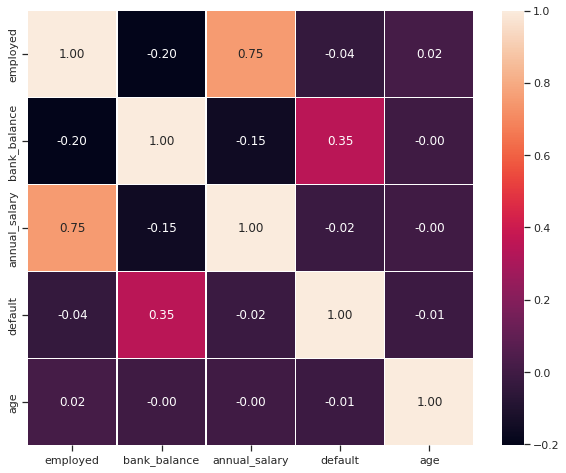

In [14]:
corr_var = df.corr()
plt.figure(figsize = (10,8))
sns.heatmap(data = corr_var, linewidths=.5, annot=True,  fmt=".2f")

###**Teste T (hipótese). Verificar se as variáveis contínuas têm influencias sobre o default.**

**H0 = Não tem diferença de médias** ('pvalue' maior que 0,05)

**H1 = Há diferença entre as médias** ('pvalue' menor que 0,05)

In [19]:
import statsmodels.api as sm
import statsmodels.stats.multicomp


from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats

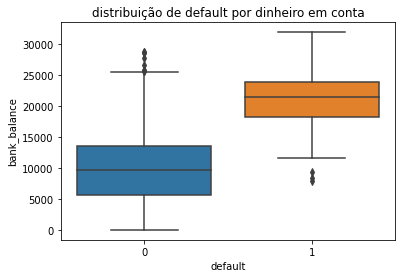

In [ ]:
sns.boxplot(x=df.default, y=df.bank_balance)
plt.title('distribuição de default por dinheiro em conta')
plt.show()

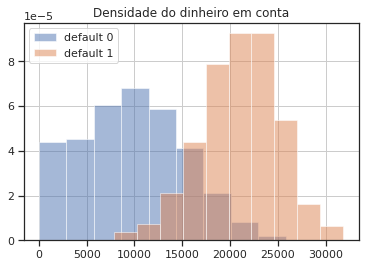

In [16]:
df[df.default==0]['bank_balance'].hist(density=True, alpha=0.5)
df[df.default==1]['bank_balance'].hist(density=True, alpha=0.5)
plt.legend(['default 0', 'default 1'])
plt.title('Densidade do dinheiro em conta')
plt.show()

In [24]:
stats.ttest_ind(df[df.default==0]['bank_balance'], df[df.default==1]['bank_balance'])

Ttest_indResult(statistic=-37.37400143369203, pvalue=2.775378859616818e-286)

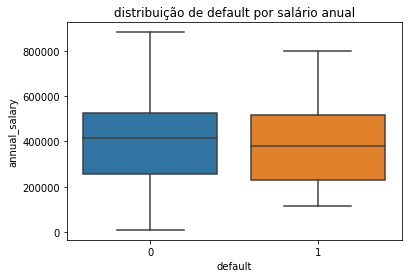

In [ ]:
sns.boxplot(x=df.default, y=df.annual_salary)
plt.title('distribuição de default por salário anual')
plt.show()

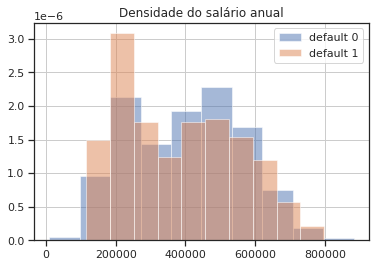

In [25]:
df[df.default==0]['annual_salary'].hist(density=True, alpha=0.5)
df[df.default==1]['annual_salary'].hist(density=True, alpha=0.5)
plt.legend(['default 0', 'default 1'])
plt.title('Densidade do salário anual')
plt.show()

In [26]:
stats.ttest_ind(df[df.default==0]['annual_salary'], df[df.default==1]['annual_salary'])

Ttest_indResult(statistic=1.9873388048344307, pvalue=0.04691210338278154)

Ambos 'pvalue' deram menor que 0,05 (5%), logo, rejeitamos a hipótese 0 de que ambos "annual salary" e "bank balance" não afetam no default.

## Feature Engineering


Tratamento de outliers e 'feature scaling' das variáveis contínuas.
Limpar outliers e escalar as features são boas práticas que ajudam a melhorar o desempenho do nosso modelo.

Também converteremos variáveis categóricas em numéricas.

In [33]:
## Remoção Outlier por IQR
def iqr_remove(df,col):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  return df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]

In [35]:
df.shape

(10000, 6)

In [37]:
iqr_remove(df,'bank_balance').shape

(9969, 6)

In [46]:
iqr_remove(df,'annual_salary').shape

(10000, 6)

In [38]:
df = iqr_remove(df,'bank_balance').shape

###Scalling e Normalização

In [ ]:
!pip install category_encoders

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import OrdinalEncoder

In [51]:
z_score = StandardScaler()
min_max = MinMaxScaler()
robust = RobustScaler()

In [56]:
df1 = df

In [57]:
df1.bank_balance = min_max.fit_transform(df[['bank_balance']])

In [58]:
df1.annual_salary = min_max.fit_transform(df[['annual_salary']])

In [60]:
ta_encoder = TargetEncoder(cols='age')
df1['age'] = ta_encoder.fit_transform(df1['age'], df[['default']])

In [62]:
ta_encoder = TargetEncoder(cols='sex')
df1['sex'] = ta_encoder.fit_transform(df1['sex'], df[['default']])

In [65]:
ta_encoder = TargetEncoder(cols='employed')
df1['employed'] = ta_encoder.fit_transform(df1['employed'], df[['default']])

In [66]:
df1.tail()

,employed,bank_balance,annual_salary,default,age,sex
9995,0.029195,0.268076,0.717488,0,0.023904,0.033577
9996,0.029195,0.285557,0.259524,0,0.035573,0.033016
9997,0.029195,0.318503,0.795032,0,0.024096,0.033577
9998,0.029195,0.591116,0.493213,0,0.036036,0.033016
9999,0.043139,0.075695,0.221084,0,0.044053,0.033016


##Modelagem

Vamos utilizar o algortimo K-NN (Vizinhos próximos) para realizar a classificação conforme nossas features já formatadas. Separaremos nosso conjunto em conjunto de treino e de teste.

Ultilizaremos 'gridsearch' para procurar o melhor hiperparâmetro (k). Técnica de cross-validation para checar conjunto de treino/teste, e se precisar, técnicas de regularização (L1 e L2).

Também utilizaremos técnicas de balanceamento, já que nosso dataset se encontra bem desbalanceado. Utilizaremos o 'SMOTEEN'. 

In [75]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from collections import Counter
from imblearn.over_sampling import (SMOTE, RandomOverSampler)
from imblearn.combine import SMOTEENN

In [68]:
target = df['default']

In [69]:
dfx = df1.drop('default', axis = 1)

In [80]:
X = dfx
y = target

In [81]:
#Contagem de 'default'
counter = Counter(y)
print(counter)

Counter({0: 9667, 1: 333})


In [82]:
smteen = SMOTEENN()

In [83]:
X, y = smteen.fit_resample(X, y)

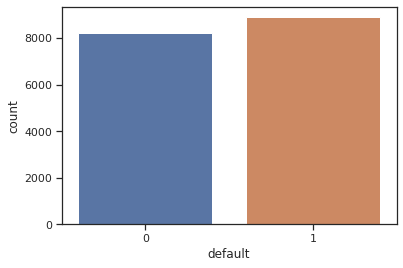

In [84]:
balanceadosmote = sns.countplot(x=y)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

###Grid Search

In [89]:
knn = KNeighborsClassifier(n_neighbors=5, p=2)

In [86]:
# Vamos definir um range de 1 a 30 vizinhos
k_list = list(range(1,31))

In [90]:
grid_params = {
    "n_neighbors": k_list,
    "metric": ["minkowski", "euclidian", "manhattan"]
}

In [91]:
grid = GridSearchCV(knn, grid_params, cv=5, scoring='precision')

In [92]:
grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py", line 437, in _fit
    self._check_algorithm_metric()
  File "/usr/local/lib/python3.7/dist-packages/sklearn/n

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'euclidian', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='precision')

In [93]:
grid.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 2,
 'p': 2,
 'weights': 'uniform'}

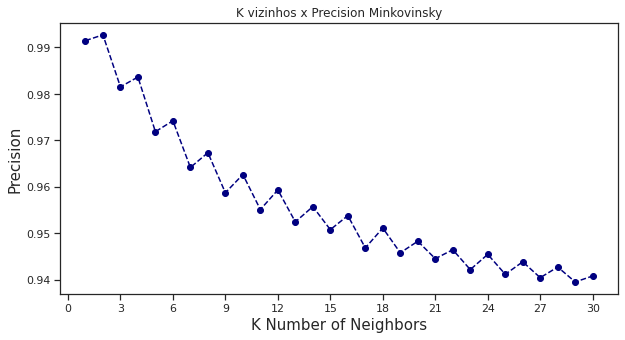

In [94]:
graphic = grid.cv_results_['mean_test_score']

plt.figure(figsize=(10,5))
plt.plot(k_list,graphic[:len(k_list)],color='navy',linestyle='dashed',marker='o')
plt.xlabel('K Number of Neighbors', fontdict={'fontsize': 15})
plt.ylabel('Precision', fontdict={'fontsize': 15})
plt.title('K vizinhos x Precision Minkovinsky')
plt.xticks(range(0,31,3),)
plt.show()

Com o grid Search aplicado, podemos ver que com 2 vizinhos (k) e distância Minkovinsky (p = 1) , nosso algoritmo acerta mais positivos.

### Instanciando Modelo KNN e Avaliação das métricas

In [96]:
knn = KNeighborsClassifier(n_neighbors=2, p=1) 

In [97]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=2, p=1)

In [98]:
knn.score(X_test,y_test)

0.9941611521992993

In [103]:
y_pred = knn.predict(X_test)
print(y_pred)

[0 1 0 ... 1 0 1]


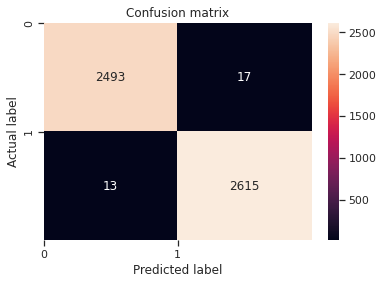

In [102]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
ax = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g')

class_names=['0', '1']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [101]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2510
           1       0.99      1.00      0.99      2628

    accuracy                           0.99      5138
   macro avg       0.99      0.99      0.99      5138
weighted avg       0.99      0.99      0.99      5138



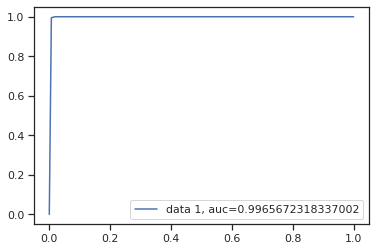

In [105]:
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Encontrando o melhor 'treshold'

J = TruePositiveRate – FalsePositiveRate

In [106]:
J = tpr - fpr
ix = np.argmax(J)

In [107]:
print('Best Threshold=%f, J-Index =%.3f' % (thresholds[ix], J[ix]))

Best Threshold=1.000000, J-Index =0.988


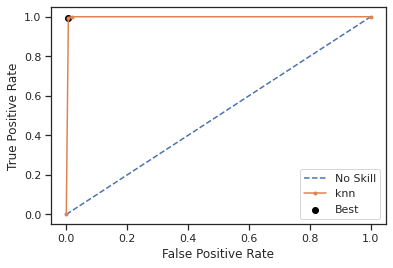

In [114]:
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='knn')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

###Cross-Validation


In [110]:
from sklearn.model_selection import cross_val_score

In [112]:
scores = cross_val_score(knn, df1.drop('default',axis=1), df1.default, cv=4, scoring='precision')
scores

array([0.61111111, 0.46666667, 0.5       , 0.46875   ])

In [113]:
print(f"Precision média {scores.mean()*100:.2f}% +/- {scores.std()*100:.2f}%")

Precision 51.16% +/- 5.89%


##Conclusão

Vimos pela 'EDA' que as variáveis contínuas têm altas influências sobre o default.
Nosso modelo está otimizado com os melhores hiperparâmetros, com taxa de precisão altíssima; podendo assim, providenciar um auxílio a financeira quando precisar saber (de acordo com as características fornecidas) se o cliente tem potencial em ser default, ou não.